<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/testing/base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.1,validation_size=64,test_size=64,seed_val=101):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [4]:
def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

In [5]:
def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [6]:

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [7]:
def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [8]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()


In [9]:


def dehaze_net():
    
    inputs = tf.keras.Input(shape = [412,548,3])
    conv1 = Conv2D(input_shape = (550, 413, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(inputs)
    conv2 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
    
    #model = Model(inputs = x, outputs = output)
    
    return Model(inputs = inputs, outputs = 

output)



In [10]:
epochs = 1
batch_size = 8
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/dataset/clear_images', hazy_img_path = './drive/MyDrive/dataset/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net =dehaze_net()

#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")


In [10]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()




Start of epoch 0 [===]  -  Training Loss: 0.3306

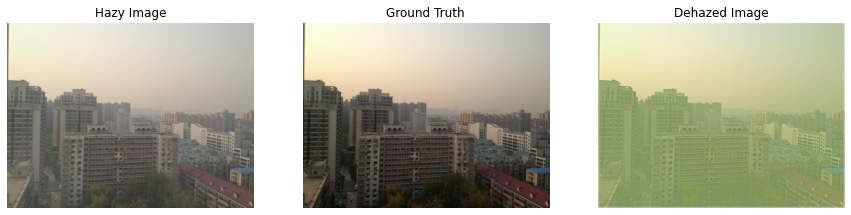

  -  Validation Loss: 0.0707  -   Time taken: 617.58s
INFO:tensorflow:Assets written to: trained_model/assets
CPU times: user 35.6 s, sys: 3.74 s, total: 39.3 s
Wall time: 10min 18s


In [11]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


In [159]:
net.save('./drive/MyDrive/nets/testnet')
model=net
model.build([413,550,3])
model.summary()



INFO:tensorflow:Assets written to: ./drive/MyDrive/nets/testnet/assets
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 412, 548, 3)  12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 412, 548, 3)  84          conv2d_5[0][0]                   
__________________________________________________________________________________________________
tf.concat_3 (TFOpLambda)        (None, 412, 548, 6)  0           conv2d_5[0][0]                   
                     

In [11]:


import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    n=0
    _,_,c=dataset_preposses()
    test_data=gen_dataset(c)
    print(c)
    for i in test_data:
      hazy_img = tf.io.read_file(i[0])
      hazy_img = tf.io.decode_jpeg(hazy_img, channels = 3)
      hazy_img = tf.image.resize(hazy_img, size = (412,548), antialias = True)
      gt_img = tf.io.read_file(i[1])
      gt_img = tf.io.decode_jpeg(gt_img, channels = 3)
      gt_img = tf.image.resize(gt_img, size = (412,548), antialias = True)

      hazy_img =hazy_img / 255.0
      gt_img=gt_img/255.0
      hazy_img1 = tf.expand_dims(hazy_img, axis = 0)
      #print(type(hazy_img))
      dehaze = net(hazy_img1)
      im=dehaze[0]
      #print(im.shape)
      directory = '/content/drive/MyDrive/demo/gt'
      os.chdir(directory)
      filename = str(n) + '_outdoor_gt.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
      tf.keras.preprocessing.image.save_img( filename,gt_img)
      
      directory = '/content/drive/MyDrive/demo/gen'
      os.chdir(directory)
      filename = str(n) + '_outdoor_gen.jpg'
      #print(filename)
      tf.keras.preprocessing.image.save_img(filename, im)
      

      os.chdir('/content/drive/MyDrive/demo/haze')
      filename = str(n) + '_outdoor_haze.jpg'
      #print(filename)
      tf.keras.preprocessing.image.save_img(filename,hazy_img)
      n+=1;
      print(n,end=' ')
      #print(i[0])
      #print(i[1])

In [12]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
evaluate_gen(net)

['/content/drive/MyDrive/dataset/haze/0799_0.85_0.1.jpg', '/content/drive/MyDrive/dataset/haze/0607_0.9_0.16.jpg', '/content/drive/MyDrive/dataset/haze/0740_0.85_0.1.jpg', '/content/drive/MyDrive/dataset/haze/0631_0.85_0.12.jpg', '/content/drive/MyDrive/dataset/haze/0815_0.95_0.16.jpg', '/content/drive/MyDrive/dataset/haze/0668_1_0.16.jpg', '/content/drive/MyDrive/dataset/haze/0555_1_0.2.jpg', '/content/drive/MyDrive/dataset/haze/0479_0.8_0.2.jpg', '/content/drive/MyDrive/dataset/haze/0659_1_0.08.jpg', '/content/drive/MyDrive/dataset/haze/0789_1_0.08.jpg', '/content/drive/MyDrive/dataset/haze/0667_0.85_0.04.jpg', '/content/drive/MyDrive/dataset/haze/0746_1_0.16.jpg', '/content/drive/MyDrive/dataset/haze/0643_0.9_0.1.jpg', '/content/drive/MyDrive/dataset/haze/0495_0.8_0.1.jpg', '/content/drive/MyDrive/dataset/haze/0655_0.8_0.06.jpg', '/content/drive/MyDrive/dataset/haze/0710_0.85_0.16.jpg', '/content/drive/MyDrive/dataset/haze/0550_0.9_0.06.jpg', '/content/drive/MyDrive/dataset/haze/067